In [1]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is enabled!")
    except RuntimeError as e:
        print(e)

2025-05-07 17:14:28.895524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746638069.117569      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746638069.175785      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is enabled!


## Sentiment Analysis with LSTM, BERT, and BART

##### Section 8B

##### K213215 Zohaib Saqib
##### K214691 Syed Onais Ali Shah
##### K213192 Muhammad

In this project, we employed different Neural Network and Transformer architectures, specifically LSTM, BERT, and BART, for Sentiment Analysis task on the Sentiment140 Tweets dataset

#### Importing Libraries

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, InputLayer, Bidirectional
from tensorflow.keras import models, layers
from transformers import TFAutoModel, AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

TOP_WORDS = 8000
MAX_WORDS = 128
bert_checkpoint = "distilbert/distilbert-base-uncased"
bart_checkpoint = "sshleifer/distilbart-cnn-12-6"
dataset_path = '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv'

### Loading Data

In [3]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()


def load_data():
    df = pd.read_csv(dataset_path, encoding='latin-1', header=None)
    df = df[[0, 5]]
    df.columns = ['sentiment', 'text']

    label_map = {0: 0, 4: 1}
    df['sentiment'] = df['sentiment'].map(label_map)
    df['cleaned_text'] = df['text'].apply(clean_text)

    return df

### LSTM

#### Data Loading and Pre-processing

In [4]:
def pre_processing():
    df = load_data()

    tokenizer = Tokenizer(num_words=TOP_WORDS)
    tokenizer.fit_on_texts(df['cleaned_text'])
    sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
    padded_sequences = sequence.pad_sequences(sequences, maxlen=MAX_WORDS)

    labels = df['sentiment'].values

    X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

    return (X_train, y_train, X_val, X_test, y_val, y_test)

In [5]:
X_train, y_train, X_val, X_test, y_val, y_test = pre_processing()

#### Defining the Model

In [7]:
lstm_model = Sequential([
    InputLayer(shape=(500,)),
    Embedding(TOP_WORDS, 100),
    Bidirectional(LSTM(512)),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [8]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 500, 100)            │         800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1024)                │       2,510,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,311,873 (12.63 MB)

 Trainable params: 3,311,873 (12.63 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the Model

In [9]:
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=256,
    verbose=1,
)

Epoch 1/5


I0000 00:00:1746638197.498898      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 641s 127ms/step - accuracy: 0.7723 - loss: 0.4718 - val_accuracy: 0.8139 - val_loss: 0.4047
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 637s 127ms/step - accuracy: 0.8193 - loss: 0.3973 - val_accuracy: 0.8214 - val_loss: 0.3928
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 636s 127ms/step - accuracy: 0.8300 - loss: 0.3772 - val_accuracy: 0.8240 - val_loss: 0.3879
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 638s 128ms/step - accuracy: 0.8380 - loss: 0.3616 - val_accuracy: 0.8264 - val_loss: 0.3865
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 641s 128ms/step - accuracy: 0.8467 - loss: 0.3446 - val_accuracy: 0.8260 - val_loss: 0.3906


#### Validation vs Training Graph

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


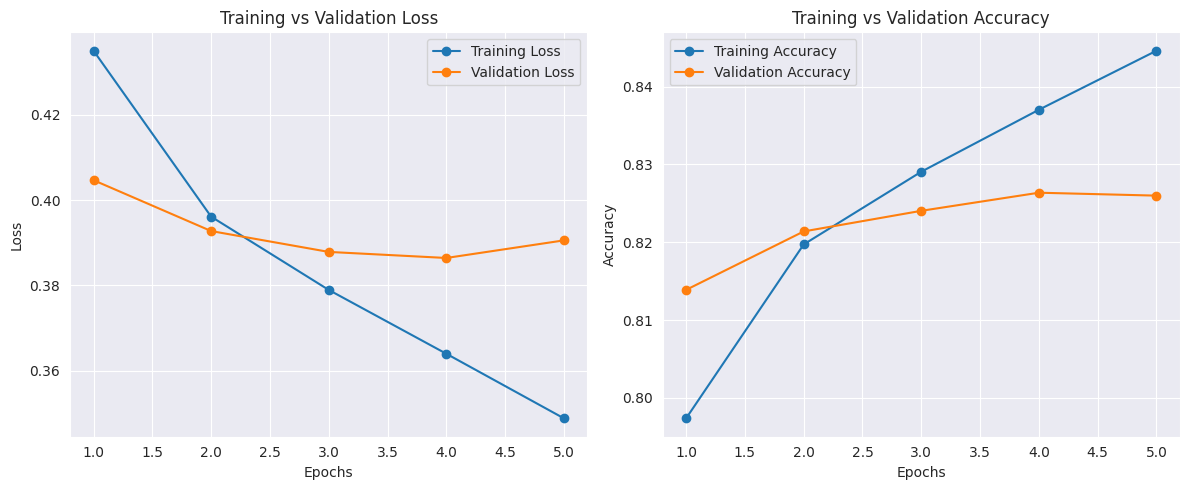

In [10]:
history_data = lstm_history.history
epochs = range(1, len(history_data['loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_data['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history_data['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history_data['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history_data['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Evaluating the Model

In [11]:
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy * 100}%')

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 71s 14ms/step - accuracy: 0.8250 - loss: 0.3915
Test loss: 0.3919324576854706
Test accuracy: 82.5124979019165%


### BERT

#### Data Pre-Processing

In [4]:
tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint)

def tokenize_function(example):
    return tokenizer(
        example['cleaned_text'],
        add_special_tokens=True,
        max_length=MAX_WORDS,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True
    )

def bert_pre_processing():
    BATCH_SIZE = 64

    df = load_data()
    df = df.sample(n=800_000).reset_index(drop=True)

    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'])

    train_data = Dataset.from_pandas(train_df)
    val_data = Dataset.from_pandas(val_df)
    test_data = Dataset.from_pandas(test_df)

    train_data = train_data.map(tokenize_function, batched=True)
    val_data = val_data.map(tokenize_function, batched=True)
    test_data = test_data.map(tokenize_function, batched=True)

    train_dataset = train_data.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols='sentiment',
        shuffle=True,
        batch_size=BATCH_SIZE,
    )
    val_dataset = val_data.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols='sentiment',
        shuffle=False,
        batch_size=BATCH_SIZE,
    )
    test_dataset = test_data.to_tf_dataset(
        columns=['input_ids', 'attention_mask'],
        label_cols='sentiment',
        shuffle=False,
        batch_size=BATCH_SIZE,
    )

    return train_dataset, val_dataset, test_dataset

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
train_dataset, val_dataset, test_dataset = bert_pre_processing()

Map:   0%|          | 0/350000 [00:00<?, ? examples/s]

Map:   0%|          | 0/75000 [00:00<?, ? examples/s]

Map:   0%|          | 0/75000 [00:00<?, ? examples/s]

I0000 00:00:1746563041.069397      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


#### Defining the Model

In [6]:
class BERTForSentimentAnalysis(tf.keras.Model):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert_model = bert_model

        if num_classes > 2:
            self.fc = Dense(num_classes, activation='softmax')
        else:
            self.fc = Dense(1, activation='sigmoid')

    def call(self, inputs):
        output = self.bert_model(inputs)
        x = output.last_hidden_state[:, 0, :]
        return self.fc(x)

In [7]:
bert_model = BERTForSentimentAnalysis(TFAutoModel.from_pretrained(bert_checkpoint), num_classes=2)

bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [8]:
bert_model.summary()

Model: "bert_for_sentiment_analysis"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Training the Model

In [9]:
bert_history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    verbose=1,
)

Epoch 1/3


I0000 00:00:1746563121.554428     104 service.cc:148] XLA service 0x7d3cbc01a970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746563121.555018     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1746563121.950654     104 assert_op.cc:38] Ignoring Assert operator bert_for_sentiment_analysis_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
I0000 00:00:1746563122.757592     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/5469 ━━━━━━━━━━━━━━━━━━━━ 20:19:08 13s/step - accuracy: 0.4844 - loss: 0.8305

I0000 00:00:1746563124.182797     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5468/5469 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7322 - loss: 0.5345

W0000 00:00:1746563707.227858     101 assert_op.cc:38] Ignoring Assert operator bert_for_sentiment_analysis_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


5469/5469 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7322 - loss: 0.5345

W0000 00:00:1746563711.399224     101 assert_op.cc:38] Ignoring Assert operator bert_for_sentiment_analysis_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
W0000 00:00:1746563833.669331     104 assert_op.cc:38] Ignoring Assert operator bert_for_sentiment_analysis_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


5469/5469 ━━━━━━━━━━━━━━━━━━━━ 724s 130ms/step - accuracy: 0.7322 - loss: 0.5345 - val_accuracy: 0.7668 - val_loss: 0.4911
Epoch 2/3
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 703s 129ms/step - accuracy: 0.7666 - loss: 0.4882 - val_accuracy: 0.7715 - val_loss: 0.4843
Epoch 3/3
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 703s 128ms/step - accuracy: 0.7703 - loss: 0.4824 - val_accuracy: 0.7652 - val_loss: 0.4873


#### Validation vs Training Graph

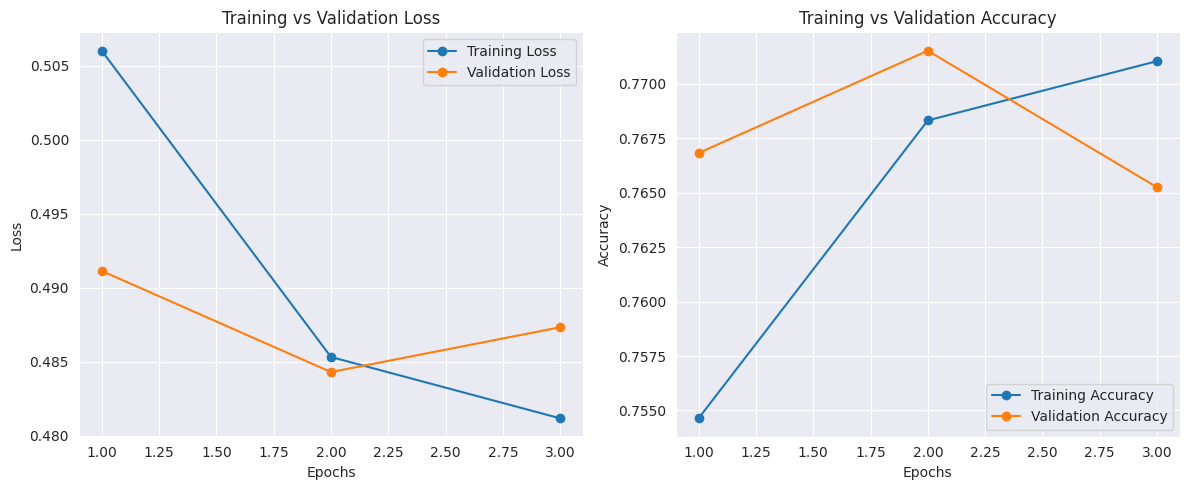

In [10]:
history_data = bert_history.history
epochs = range(1, len(history_data['loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_data['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history_data['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history_data['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history_data['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Evaluating the Model

In [11]:
loss, accuracy = bert_model.evaluate(test_dataset)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy * 100}%')

1172/1172 ━━━━━━━━━━━━━━━━━━━━ 124s 106ms/step - accuracy: 0.7667 - loss: 0.4858
Test loss: 0.48604536056518555
Test accuracy: 76.5986680984497%


### BART

In [13]:
import torch
from transformers import BartForSequenceClassification, BartTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

#### Data Pre-Processing

In [21]:
tokenizer = AutoTokenizer.from_pretrained(bart_checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["cleaned_text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_WORDS
    )


def bart_pre_processing():
    BATCH_SIZE = 32

    df = load_data()
    df = df.sample(n=250_000).reset_index(drop=True)

    train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["sentiment"])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["sentiment"])
    
    train_dataset = Dataset.from_pandas(train_df[["cleaned_text", "sentiment"]])
    val_dataset = Dataset.from_pandas(val_df[["cleaned_text", "sentiment"]])
    test_dataset = Dataset.from_pandas(test_df[["cleaned_text", "sentiment"]])
    
    dataset = DatasetDict({
        "train": train_dataset,
        "test": test_dataset,
        "validation": val_dataset
    })

    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    tokenized_datasets = tokenized_datasets.rename_column("sentiment", "labels")
    tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=BATCH_SIZE)
    val_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=BATCH_SIZE)

    return (train_dataloader, val_dataloader, test_dataloader)

In [22]:
train_dataloader, val_dataloader, test_dataloader = bart_pre_processing()

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

#### Defining the Model

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [24]:
bart = BartForSequenceClassification.from_pretrained(bart_checkpoint, num_labels=2)
bart.to(device)

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at sshleifer/distilbart-cnn-12-6 and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

BartForSequenceClassification(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
   

#### Training the Model

In [33]:
epochs = 3
learning_rate = 2e-5
total_steps = len(train_dataloader) * epochs

optimizer = AdamW(bart.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [26]:
def train():
    bart.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = bart(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


def evaluate():
    bart.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = bart(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, accuracy

In [27]:
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    train_loss = train()
    print(f"Train Loss: {train_loss:.4f}")

    val_loss, val_acc = evaluate()
    print(f"Eval Loss: {val_loss:.4f}")
    print(f"Eval Accuracy: {val_acc:.4f}")


Epoch 1/3


Training: 100%|██████████| 6250/6250 [1:46:22<00:00,  1.02s/it]


Train Loss: 0.3331


Evaluating: 100%|██████████| 782/782 [04:19<00:00,  3.02it/s]


Eval Loss: 0.3072
Eval Accuracy: 0.8702

Epoch 2/3


Training: 100%|██████████| 6250/6250 [1:46:18<00:00,  1.02s/it]


Train Loss: 0.2395


Evaluating: 100%|██████████| 782/782 [04:19<00:00,  3.01it/s]


Eval Loss: 0.3166
Eval Accuracy: 0.8755

Epoch 3/3


Training: 100%|██████████| 6250/6250 [1:46:19<00:00,  1.02s/it]


Train Loss: 0.1529


Evaluating: 100%|██████████| 782/782 [04:18<00:00,  3.02it/s]

Eval Loss: 0.3650
Eval Accuracy: 0.8712


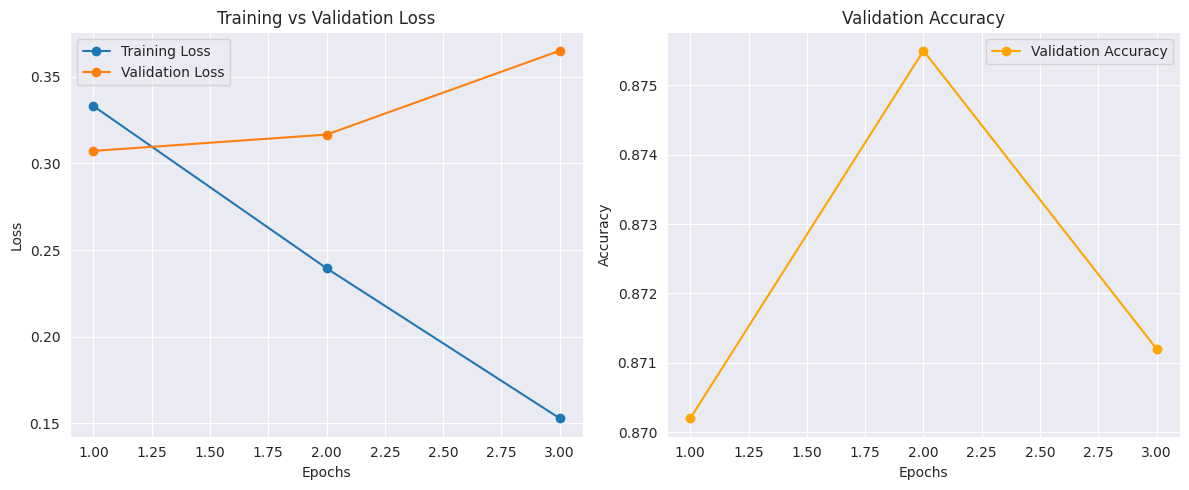

In [35]:
# didnt store the values :)
train_losses = [0.3331, 0.2395, 0.1529]
val_losses = [0.3072, 0.3166, 0.3650]
val_accuracies = [0.8702, 0.8755, 0.8712]
num_epochs = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(num_epochs, train_losses, label='Training Loss', marker='o')
plt.plot(num_epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(num_epochs, val_accuracies, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Evaluating the Model

In [28]:
def test_evaluate():
    bart.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = bart(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    avg_loss = total_loss / len(test_dataloader)
    accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, accuracy

In [29]:
test_loss, test_acc = test_evaluate()
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Testing: 100%|██████████| 782/782 [04:17<00:00,  3.04it/s]

Test Loss: 0.3481
Test Accuracy: 0.8780
